In [1]:
# pytorch libraries (for comparison)
import torch
from torch import nn
from torch.nn import functional as F
from torch import optim

# Own libraries
from dl_lib import *
from test import *

# Visualization
%matplotlib inline
import numpy as np
from matplotlib import pyplot as plt

SEED = 1
torch.manual_seed(SEED)
random.seed(SEED)

## Performance Analysis

In [2]:
def test_pytorch(train_dataset, test_dataset, verbose=True):
    """Train a similar model using the input datasets"""
    torch.set_grad_enabled(True)
    
    train_inputs, train_targets, train_classes = train_dataset
    test_inputs, test_targets, test_classes = test_dataset
    
    # PyTorch identical model
    pt_model = nn.Sequential(
        nn.Linear(2, 25), 
        nn.ReLU(),
        nn.Linear(25, 25), 
        nn.ReLU(),
        nn.Linear(25, 25), 
        nn.ReLU(),
        nn.Linear(25, 2))

    # Loss
    criterion = nn.MSELoss()

    # Optimizer
    optimizer = optim.SGD(pt_model.parameters(), LEARNING_RATE)

    pt_model.train(True)
    
    if verbose:
        print("Training (with PyTorch):")

    # Start time
    t0 = time.time()
    for e in range(EPOCHS):

        sum_loss = 0
        # iterate over each batch and update weights (replace train_targets with train_classes when using CrossEntropyLoss)
        for input_batch, target_batch in zip(train_inputs.split(BACTH_SIZE), train_targets.split(BACTH_SIZE)):

            # computing predicted values and loss
            predicted = pt_model(input_batch)
            loss = criterion(predicted, target_batch)

            # averaging loss over the current epoch (for consistent logging independetly of BATCH_SIZE)
            sum_loss = sum_loss + (BACTH_SIZE / train_inputs.shape[0]) * loss.detach()

            # Optimizer step
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

        if verbose:
            print("Epoch {} | Loss {:.3f}".format(e+1, sum_loss))

    # Stop time
    t1 = time.time()
    dt_pt = t1 - t0

    # compute accuracy
    train_acc_pt = accuracy(pt_model, train_inputs, train_classes)
    test_acc_pt = accuracy(pt_model, test_inputs, test_classes)

    if verbose:
        print("---------------------")
        print("Train accuracy: {} | Test accuracy: {}".format(train_acc_pt, test_acc_pt))
        print("Time elapsed; {:.3}s".format(dt_pt))
    
    torch.set_grad_enabled(False)
    
    return pt_model, train_acc_pt, test_acc_pt,  dt_pt

In [3]:
# Execute the test.py and returning the model along with the train and test datasets
ROUNDS = 50

tr_acc = torch.empty(ROUNDS)
te_acc = torch.empty(ROUNDS)
tr_acc_pt = torch.empty(ROUNDS)
te_acc_pt = torch.empty(ROUNDS)
dtime = torch.empty(ROUNDS)
dtime_pt = torch.empty(ROUNDS)

for r in range(ROUNDS):
    print("Training round {}/{}".format(r+1, ROUNDS))
    
    own_model, train_dataset, test_dataset, train_acc, test_acc, dt = test(verbose=False)
    pt_model, train_acc_pt, test_acc_pt, dt_pt = test_pytorch(train_dataset, test_dataset, verbose=False)
    
    tr_acc[r] = train_acc
    te_acc[r] = test_acc
    tr_acc_pt[r] = train_acc_pt
    te_acc_pt[r] = test_acc_pt
    dtime[r] = dt
    dtime_pt[r] = dt_pt

print("-------------------")
print("Own library:")
print("Train accuracy: {:.4}% (+-{:.4}%)".format(100 * tr_acc.mean(), 100 * tr_acc.std()))
print("Test accuracy: {:.4}% (+-{:.4}%)".format(100 * te_acc.mean(), 100 * te_acc.std()))
print("Time: {:.3}s (+-{:.2}s)".format(dtime.mean(), dtime.std()))
print("PyTorch library:")
print("Train accuracy: {:.4}% (+-{:.4}%)".format(100 * tr_acc_pt.mean(),100 * tr_acc_pt.std()))
print("Test accuracy: {:.4}% (+-{:.4}%)".format(100 * te_acc_pt.mean(),100 * te_acc_pt.std()))
print("Time: {:.3}s (+-{:.2}s)".format(dtime_pt.mean(), dtime_pt.std()))

Training round 1/50
Training round 2/50
Training round 3/50
Training round 4/50
Training round 5/50
Training round 6/50
Training round 7/50
Training round 8/50
Training round 9/50
Training round 10/50
Training round 11/50
Training round 12/50
Training round 13/50
Training round 14/50
Training round 15/50
Training round 16/50
Training round 17/50
Training round 18/50
Training round 19/50
Training round 20/50
Training round 21/50
Training round 22/50
Training round 23/50
Training round 24/50
Training round 25/50
Training round 26/50
Training round 27/50
Training round 28/50
Training round 29/50
Training round 30/50
Training round 31/50
Training round 32/50
Training round 33/50
Training round 34/50
Training round 35/50
Training round 36/50
Training round 37/50
Training round 38/50
Training round 39/50
Training round 40/50
Training round 41/50
Training round 42/50
Training round 43/50
Training round 44/50
Training round 45/50
Training round 46/50
Training round 47/50
Training round 48/50
T

## Visualization

In [4]:
def visualization(model, title, filename, dataset, save=True):
    """Plot the predictions on a 2D plane."""
    inputs, targets, classes = dataset
    
    plt.figure(figsize=(3.6,3.6))
    plt.xlim(0,1)
    plt.ylim(0,1)
    plt.title(title + '\n(green=1, red=0)')
    
    if isinstance(model, Sequential):
        pred = model.predict(inputs)
    else:
        pred = model(inputs)
        
    _, pred_class = pred.max(1)
    
    # Scatter training set
    plt.scatter(inputs[pred_class==1,0], inputs[pred_class==1,1], s=4, marker='o', c='g')
    plt.scatter(inputs[pred_class==0,0], inputs[pred_class==0,1], s=4, marker='o', c='r')

    # Plot circle
    x = np.linspace(0.5 - 1/math.sqrt(2*math.pi), 0.5 + 1/math.sqrt(2*math.pi), 100)
    plt.plot(x,(1/(2*math.pi) - (x - 0.5)**2)**(1/2) + 0.5, 'k-.')
    plt.plot(x,- (1/(2*math.pi) - (x - 0.5)**2)**(1/2) + 0.5, 'k-.')
    plt.savefig('figures/' + filename + '.png')

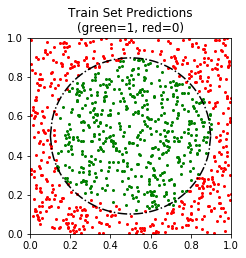

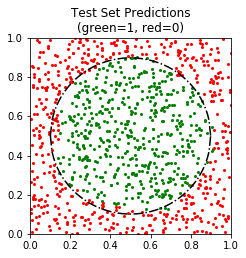

In [5]:
# Train dataset performance plot
visualization(own_model, 'Train Set Predictions', 'plot_tr_predictions', train_dataset, save=True)

# Test dataset performance plot
visualization(own_model, 'Test Set Predictions', 'plot_te_predictions', test_dataset, save=True)

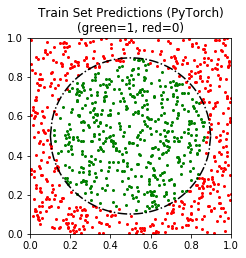

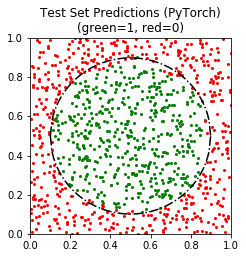

In [6]:
# Train dataset performance plot (pytorch)
visualization(pt_model, 'Train Set Predictions (PyTorch)', 'plot_tr_predictions_pytorch', train_dataset, save=True)

# Test dataset performance plot (pytorch)
visualization(pt_model, 'Test Set Predictions (PyTorch)', 'plot_te_predictions_pytorch', test_dataset, save=True)